In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.2 MB/s eta 0:00:

In [2]:
import pandas as pd
import numpy as np

from darts import TimeSeries
from darts.models import ExponentialSmoothing

import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/ML_Hillel/HW_L19_TimeSeries/"

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Зчитуємо датасет:
df = pd.read_csv(path + 'T10Y2Y.csv', parse_dates=['observation_date'], header=0, quotechar=',')
df

,observation_date,T10Y2Y
0,2019-12-27,0.29
1,2019-12-30,0.32
2,2019-12-31,0.34
3,2020-01-01,NaN
4,2020-01-02,0.30
...,...,...
1301,2024-12-23,0.29
1302,2024-12-24,0.30
1303,2024-12-25,NaN
1304,2024-12-26,0.28


In [44]:
df.tail(20)

,observation_date,T10Y2Y
1286,2024-12-02,0.02
1287,2024-12-03,0.06
1288,2024-12-04,0.06
1289,2024-12-05,0.02
1290,2024-12-06,0.05
1291,2024-12-09,0.07
1292,2024-12-10,0.07
1293,2024-12-11,0.11
1294,2024-12-12,0.14
1295,2024-12-13,0.15


In [45]:
# Заповнення пропусків попередніми значеннями
df.ffill(inplace=True)
df

,observation_date,T10Y2Y
0,2019-12-27,0.29
1,2019-12-30,0.32
2,2019-12-31,0.34
3,2020-01-01,0.34
4,2020-01-02,0.30
...,...,...
1301,2024-12-23,0.29
1302,2024-12-24,0.30
1303,2024-12-25,0.30
1304,2024-12-26,0.28


Бачимо, що дані у датасеті  - за 5 років: у період 2019-12-27 - 2024-12-27.
Тому зручно для валідаційної вибірки взяти 20%, а саме, дані з 2023-12-27

#Darts

In [48]:
#Перетворюємо DataFrame у формат TimeSeries для подальшого аналізу
series = TimeSeries.from_dataframe(df, time_col='observation_date', value_cols='T10Y2Y')

#Розділення даних на навчальний і валідаційний набори (у співвідношенні 4:1, тобто, 1/5 - для валідаційної вибірки)
train, val = series.split_before(pd.Timestamp('2023-12-27'))

#Застосовуюємо модель експоненційного згладжування, яка використовується для прогнозування часових рядів
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val)) #прогноз на величину валідаційної вибірки, тобто на рік

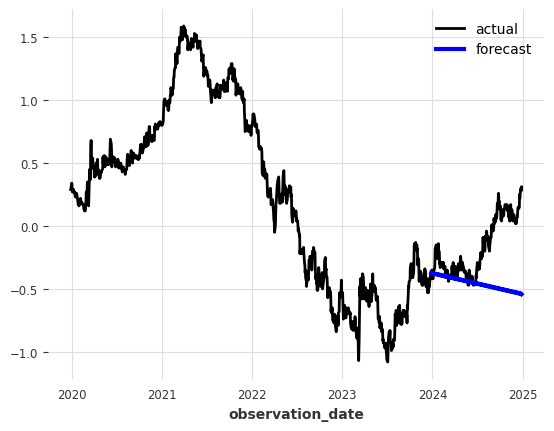

In [49]:
#Візуалізуємо прогноз
series.plot(label='actual')
prediction.plot(label='forecast', lw=3, color = 'b')
plt.legend()

Бачимо, що модель вийшла не надто вдала. Застосуємо сезонність до моделі експоненційного згладжування:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


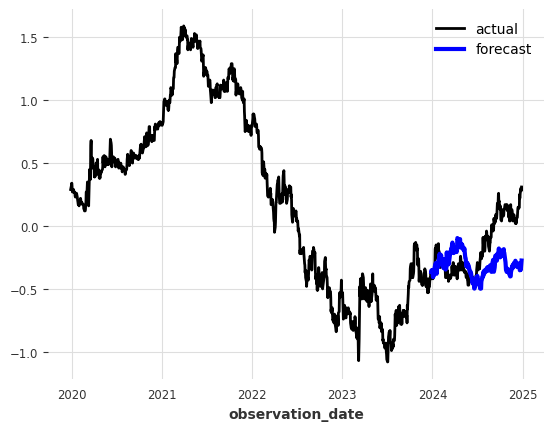

In [9]:
#Застосовуюємо модель експоненційного згладжування, яка використовується для прогнозування часових рядів
model = ExponentialSmoothing(seasonal_periods=252)
model.fit(train)
prediction = model.predict(len(val)) #прогноз на величину валідаційної вибірки, тобто на рік

series.plot(label='actual')
prediction.plot(label='forecast', lw=3, color = 'b')
plt.legend()


Бачимо, що результат прогнозу покращився, але все ще на другу половину року суттєво відрізняється від дійсних значень.

Спробуємо використати іншу модель - Prophet, вбудований у Darts

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2ez25k5/mpihim9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2ez25k5/hhy4303y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90836', 'data', 'file=/tmp/tmpf2ez25k5/mpihim9b.json', 'init=/tmp/tmpf2ez25k5/hhy4303y.json', 'output', 'file=/tmp/tmpf2ez25k5/prophet_modelw_5p9h4c/prophet_model-20250102112138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


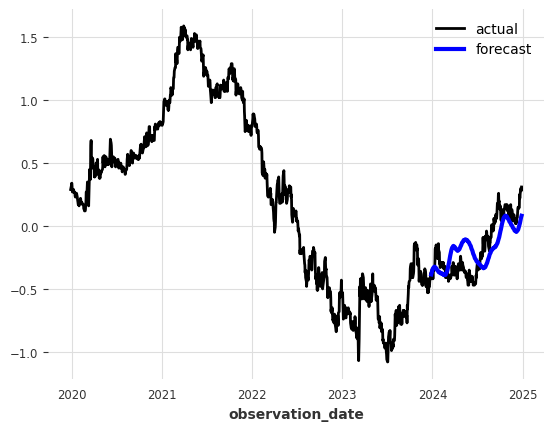

In [10]:
from darts.models import Prophet

# Створення моделі Prophet
model = Prophet()

model.fit(train)
prediction = model.predict(len(val)) #прогноз на величину валідаційної вибірки, тобто на рік

series.plot(label='actual')
prediction.plot(label='forecast', lw=3, color = 'b')
plt.legend()


Як бачимо, Prophet дуже вдало здійснив прогноз: прогнозні значення близькі до реальних

Ще перевіримо модель KalmanForecaster

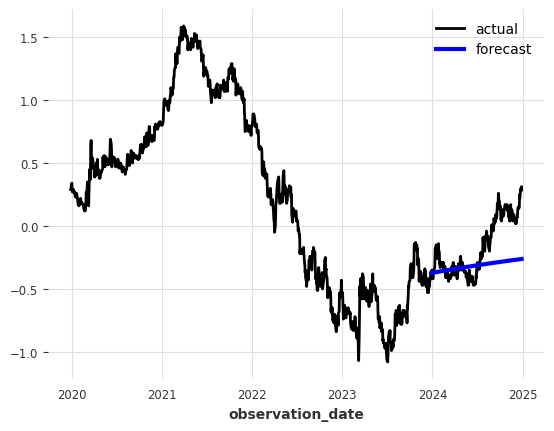

In [11]:
from darts.models import KalmanForecaster
model = KalmanForecaster()
model.fit(train)


# Прогноз
prediction = model.predict(len(val))

# Візуалізація
series.plot(label='actual')
prediction.plot(label='forecast', lw=3, color='b')
plt.legend()
plt.show()

Модель KalmanForecaster правильно відмінила тренд у сторону зростання значень, але відобразила прогноз як лінійну характеристику. Оскільки значення датасету є від'ємні, то для не можемо застосувати мультиплікативні параметри моделі KalmanForecaster (а адитивні параметри для моделі не працюють), для подальшого аналізу потрібно робити препроцесинг датасету, зсувом всіх даних вверх, нормалізацією чи логарифмуванням.

Перевіримо ще окрему модель Prophet

#Prophet

In [52]:
from prophet import Prophet
from sklearn.model_selection import train_test_split

model = Prophet()

#Зміна назв колонок через особливість вимог до моделі Prophet
df_prophet = df.rename(columns={'observation_date': 'ds', 'T10Y2Y': 'y'}, inplace=False)

# Поділ на тренувальну і валідаційну вибірки без перемішування
train, val = train_test_split(df_prophet, test_size=0.2, shuffle=False)

model.fit(train)

future = model.make_future_dataframe(periods=365) #тут ставимо 365 днів, оскільки прогноз йде на всі календарні дні

#Прогноз із зазначенням інтервалів довіри
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2ez25k5/vhfyb60x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf2ez25k5/b4hibrwk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61065', 'data', 'file=/tmp/tmpf2ez25k5/vhfyb60x.json', 'init=/tmp/tmpf2ez25k5/b4hibrwk.json', 'output', 'file=/tmp/tmpf2ez25k5/prophet_modela2e905yx/prophet_model-20250102125443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1404,2024-12-22,0.103290,-0.401204,0.702997
1405,2024-12-23,0.043695,-0.493427,0.643580
1406,2024-12-24,0.053455,-0.474928,0.648586
1407,2024-12-25,0.060396,-0.465408,0.653402
1408,2024-12-26,0.068688,-0.468456,0.676541


In [53]:
val.tail()

,ds,y
1301,2024-12-23,0.29
1302,2024-12-24,0.30
1303,2024-12-25,0.30
1304,2024-12-26,0.28
1305,2024-12-27,0.31


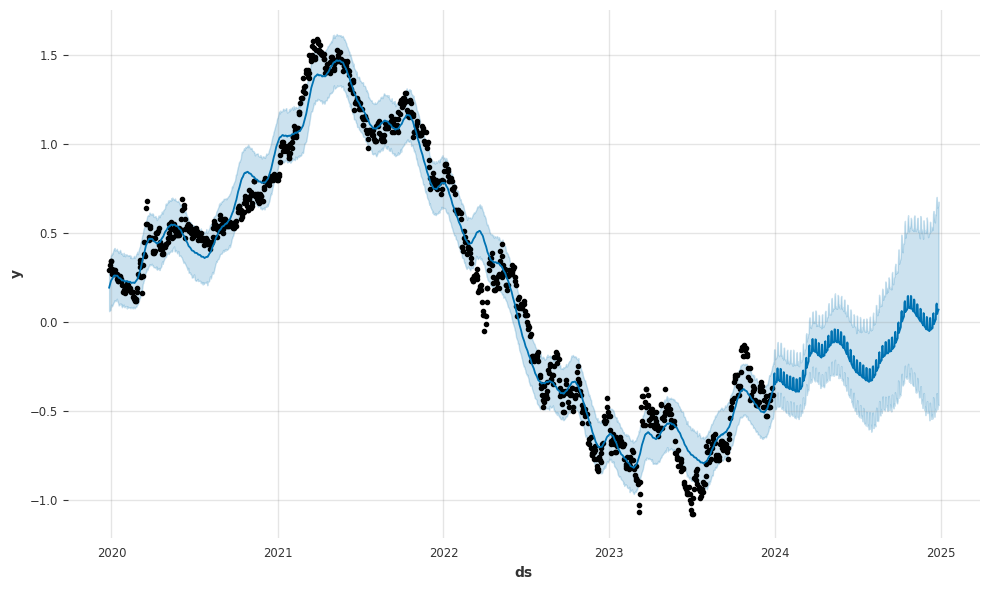

In [54]:
fig1 = model.plot(forecast)

Порівняємо прогноз з актуальними даними (червоний колір)

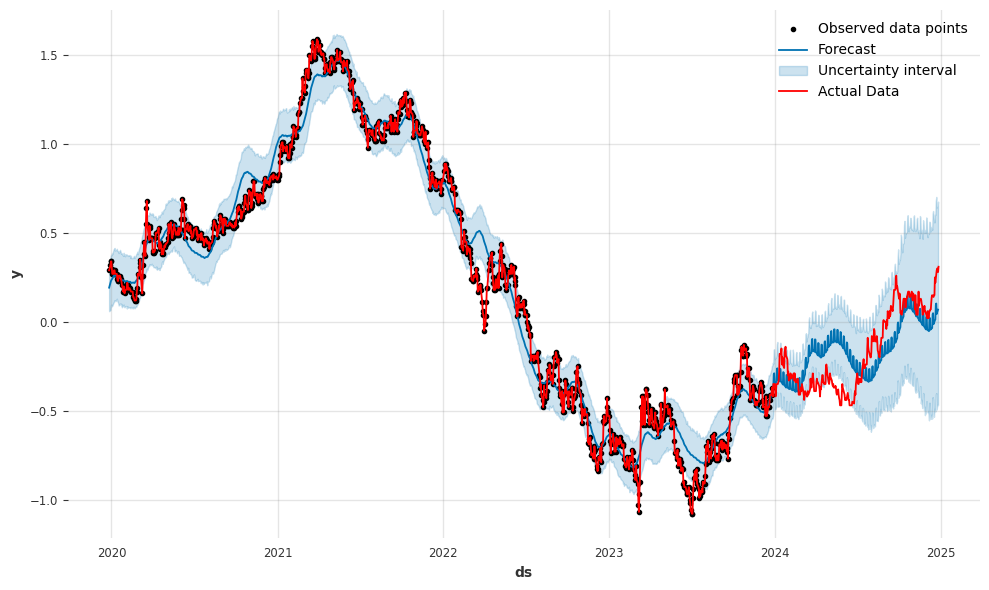

In [55]:
import matplotlib.pyplot as plt

# Побудова графіка прогнозу з Prophet
fig1 = model.plot(forecast)

# Додавання реальних даних до графіка
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual Data', color='red')

# Додавання легенди
plt.legend()
plt.show()

З графіка бачимо, що модель Prophet дещо занизила у прогнозі значення у 2 кварталі 2024 року, але друге півріччя досить добре спрогнозувала.

На завершення - ілюстрація прогнозу з використанням бібліотеки plotly

In [20]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)